In [1]:
# Install required packages
!pip install yfinance transformers torch beautifulsoup4 scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
"""
Market Trend Prediction Module
==============================

A modular system that predicts stock market trends using:
1. PyTorch LSTM model for price prediction
2. FinBERT for sentiment analysis of news headlines
3. Integration of both signals for trend classification

Author: AI Assistant
Date: May 30, 2025
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import requests
from bs4 import BeautifulSoup as bs
from datetime import datetime, timedelta
import re
import json
from typing import List, Tuple, Dict, Optional
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

2025-06-10 11:50:23.252136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749556223.662979      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749556223.781300      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All libraries imported successfully!


In [3]:
class StockLSTM(nn.Module):
    """PyTorch LSTM model for stock price prediction"""
    
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Take last time step
        out = self.fc(out)
        return out

print("✅ LSTM model class defined!")

✅ LSTM model class defined!


In [4]:
class MarketTrendPredictor:
    """Main class for market trend prediction combining price and sentiment analysis"""
    
    def __init__(self, time_window: int = 30):
        self.time_window = time_window
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.scaler_x = StandardScaler()
        self.scaler_y = StandardScaler()
        self.model = None
        
        print(f"🔧 Using device: {self.device}")
        print("📊 Initializing FinBERT for sentiment analysis...")
        
        # Initialize FinBERT pipeline
        try:
            self.finbert_pipe = pipeline("text-classification", model="ProsusAI/finbert")
            print("✅ FinBERT loaded successfully!")
        except Exception as e:
            print(f"⚠️ Warning: Could not load FinBERT model: {e}")
            self.finbert_pipe = None

# Test initialization
predictor = MarketTrendPredictor()

🔧 Using device: cuda
📊 Initializing FinBERT for sentiment analysis...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


✅ FinBERT loaded successfully!


In [5]:
def get_stock_info(self, ticker: str) -> dict:
    """Get current stock information and metrics"""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Extract key metrics with fallbacks
        result = {
            'ticker': ticker.upper(),
            'name': info.get('shortName', ticker.upper()),
            'current_price': info.get('currentPrice', 0.0),
            'daily_change': info.get('regularMarketChange', 0.0),
            'change_percent': info.get('regularMarketChangePercent', 0.0),
            'volume': info.get('regularMarketVolume', 0),
            'market_cap': info.get('marketCap', 0),
            'pe_ratio': info.get('trailingPE', 0.0)
        }
        
        return result
        
    except Exception as e:
        print(f"Error fetching stock info for {ticker}: {e}")
        return {
            'ticker': ticker.upper(),
            'name': ticker.upper(),
            'current_price': 0.0,
            'daily_change': 0.0,
            'change_percent': 0.0,
            'volume': 0,
            'market_cap': 0,
            'pe_ratio': 0.0
        }

def get_stock_data(self, ticker: str, days: int = 90) -> pd.DataFrame:
    """Download historical stock data"""
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days)
    
    try:
        stock_data = yf.download(
            ticker, 
            start=start_date.strftime('%Y-%m-%d'), 
            end=end_date.strftime('%Y-%m-%d'),
            interval="1d"
        )
        return stock_data
    except Exception as e:
        print(f"Error downloading stock data for {ticker}: {e}")
        return pd.DataFrame()

# Add methods to class
MarketTrendPredictor.get_stock_info = get_stock_info
MarketTrendPredictor.get_stock_data = get_stock_data

print("✅ Stock data methods added!")

✅ Stock data methods added!


In [6]:
def get_news_headlines(self, ticker: str) -> List[Tuple[str, str]]:
    """Scrape recent financial news headlines from Yahoo Finance"""
    url = f"https://finance.yahoo.com/quote/{ticker}/latest-news/"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        soup = bs(response.text, "html.parser")
        
        # Look for news items in different possible structures
        headlines = []
        
        # Try multiple selectors for Yahoo Finance news
        selectors = [
            "ul.stream-items li",
            "[data-testid='news-stream'] li",
            ".news-stream li",
            ".stream-items li"
        ]
        
        for selector in selectors:
            items = soup.select(selector)
            if items:
                for item in items:
                    try:
                        # Try different title selectors
                        title_elem = (item.find("a", class_="subtle-link") or 
                                    item.find("h3") or 
                                    item.find("a"))
                        
                        if title_elem:
                            title = title_elem.get("title") or title_elem.get_text(strip=True)
                            
                            # Try to get date
                            date_elem = item.find("div", class_="publishing")
                            if date_elem:
                                date_text = date_elem.get_text(strip=True)
                                # Parse relative dates
                                if any(x in date_text.lower() for x in ["hour", "minute", "second", "now"]):
                                    date = datetime.today().strftime('%Y-%m-%d')
                                elif "yesterday" in date_text.lower():
                                    date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
                                else:
                                    # Try to extract days ago
                                    days_match = re.search(r'(\d+)\s*day', date_text)
                                    if days_match:
                                        days_ago = int(days_match.group(1))
                                        date = (datetime.today() - timedelta(days=days_ago)).strftime('%Y-%m-%d')
                                    else:
                                        date = datetime.today().strftime('%Y-%m-%d')
                            else:
                                date = datetime.today().strftime('%Y-%m-%d')
                            
                            if title and len(title) > 10:  # Filter out very short titles
                                headlines.append((title, date))
                                
                    except Exception:
                        continue
                
                if headlines:
                    break  # Found headlines with this selector
        
        # Fallback: create some sample headlines if none found
        if not headlines:
            headlines = [
                (f"{ticker.upper()} stock movement analysis", datetime.today().strftime('%Y-%m-%d')),
                (f"Market outlook for {ticker.upper()}", datetime.today().strftime('%Y-%m-%d'))
            ]
        
        return headlines[:20]  # Limit to recent headlines
        
    except Exception as e:
        print(f"Error scraping headlines for {ticker}: {e}")
        # Return default headlines
        return [
            (f"{ticker.upper()} stock analysis", datetime.today().strftime('%Y-%m-%d')),
            (f"Market trends for {ticker.upper()}", datetime.today().strftime('%Y-%m-%d'))
        ]

# Add method to class
MarketTrendPredictor.get_news_headlines = get_news_headlines

print("✅ News scraping method added!")

✅ News scraping method added!


In [7]:
def analyze_sentiment(self, headlines: List[str]) -> Tuple[str, float, List[str]]:
    """Analyze sentiment of headlines using FinBERT"""
    if not headlines or not self.finbert_pipe:
        return "neutral", 0.5, []
    
    try:
        sentiments = []
        keywords = []
        
        for headline in headlines:
            if len(headline.strip()) < 5:  # Skip very short headlines
                continue
                
            result = self.finbert_pipe(headline)[0]
            sentiment_label = result['label'].lower()
            confidence = result['score']
            
            sentiments.append({
                'sentiment': sentiment_label,
                'confidence': confidence
            })
            
            # Extract keywords (simple approach)
            words = re.findall(r'\b[A-Za-z]{4,}\b', headline.lower())
            keywords.extend([w for w in words if w not in ['said', 'says', 'will', 'would', 'could', 'should']])
        
        if not sentiments:
            return "neutral", 0.5, []
        
        # Calculate weighted sentiment
        positive_score = sum(s['confidence'] for s in sentiments if s['sentiment'] == 'positive')
        negative_score = sum(s['confidence'] for s in sentiments if s['sentiment'] == 'negative')
        neutral_score = sum(s['confidence'] for s in sentiments if s['sentiment'] == 'neutral')
        
        total_score = positive_score + negative_score + neutral_score
        
        if total_score == 0:
            return "neutral", 0.5, list(set(keywords[:5]))
        
        # Determine overall sentiment
        if positive_score > negative_score and positive_score > neutral_score:
            overall_sentiment = "positive"
            confidence = positive_score / total_score
        elif negative_score > positive_score and negative_score > neutral_score:
            overall_sentiment = "negative"
            confidence = negative_score / total_score
        else:
            overall_sentiment = "neutral"
            confidence = neutral_score / total_score if neutral_score > 0 else 0.5
        
        return overall_sentiment, confidence, list(set(keywords[:5]))
        
    except Exception as e:
        print(f"Error in sentiment analysis: {e}")
        return "neutral", 0.5, []

# Add method to class
MarketTrendPredictor.analyze_sentiment = analyze_sentiment

print("✅ Sentiment analysis method added!")

✅ Sentiment analysis method added!


In [8]:
def prepare_lstm_data(self, df: pd.DataFrame, feature_columns: List[str] = None) -> Tuple[np.ndarray, np.ndarray]:
    """Prepare data for LSTM training/prediction"""
    if feature_columns is None:
        feature_columns = ['Open', 'High', 'Low', 'Close']
    
    if len(df) < self.time_window + 1:
        raise ValueError(f"Not enough data. Need at least {self.time_window + 1} days, got {len(df)}")
    
    x, y = [], []
    for i in range(self.time_window, len(df)):
        x.append(df[feature_columns].iloc[i-self.time_window:i].values)
        y.append(df['Close'].iloc[i])
    
    return np.array(x), np.array(y)

def train_model(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int = 50, lr: float = 0.001) -> None:
    """Train the LSTM model"""
    # Scale the data
    x_train_scaled = self.scaler_x.fit_transform(x_train.reshape(-1, x_train.shape[-1]))
    x_train_scaled = x_train_scaled.reshape(x_train.shape)
    
    y_train_scaled = self.scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    
    # Convert to tensors
    x_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).to(self.device)
    y_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(self.device)
    
    # Initialize model
    input_size = x_train.shape[-1]
    self.model = StockLSTM(input_size).to(self.device)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = optim.Adam(self.model.parameters(), lr=lr)
    
    # Training loop
    self.model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = self.model(x_tensor)
        loss = criterion(output.squeeze(), y_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# Add methods to class
MarketTrendPredictor.prepare_lstm_data = prepare_lstm_data
MarketTrendPredictor.train_model = train_model

print("✅ LSTM training methods added!")

✅ LSTM training methods added!


In [9]:
def predict_next_price(self, ticker: str) -> float:
    """Predict the next day's closing price"""
    try:
        # Get recent data
        df = self.get_stock_data(ticker, days=90)
        if df.empty or len(df) < self.time_window + 10:
            print(f"Insufficient data for {ticker}")
            return 0.0
        
        # Prepare training data
        x, y = self.prepare_lstm_data(df)
        
        # Train model
        print(f"🔄 Training LSTM model for {ticker}...")
        self.train_model(x[:-1], y[:-1], epochs=30)
        
        # Predict next price
        last_sequence = x[-1:] # Last sequence for prediction
        last_sequence_scaled = self.scaler_x.transform(last_sequence.reshape(-1, last_sequence.shape[-1]))
        last_sequence_scaled = last_sequence_scaled.reshape(last_sequence.shape)
        
        x_pred = torch.tensor(last_sequence_scaled, dtype=torch.float32).to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            pred_scaled = self.model(x_pred).cpu().numpy()
            pred_price = self.scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))[0, 0]
        
        return float(pred_price)
        
    except Exception as e:
        print(f"Error predicting price for {ticker}: {e}")
        # Fallback: return current price
        stock_info = self.get_stock_info(ticker)
        return stock_info.get('current_price', 0.0)

# Add method to class
MarketTrendPredictor.predict_next_price = predict_next_price

print("✅ Price prediction method added!")

✅ Price prediction method added!


In [10]:
def predict_market_trend(self, ticker: str) -> Dict:
    """Main function to predict market trend combining price and sentiment"""
    try:
        # Get stock information
        print(f"📊 Analyzing {ticker}...")
        stock_info = self.get_stock_info(ticker)
        current_price = stock_info['current_price']
        
        # Predict next price
        predicted_price = self.predict_next_price(ticker)
        
        # Get and analyze news sentiment
        print("📰 Getting news headlines...")
        headlines = self.get_news_headlines(ticker)
        headline_texts = [h[0] for h in headlines]
        print("🔍 Analyzing sentiment...")
        sentiment, sentiment_confidence, keywords = self.analyze_sentiment(headline_texts)
        
        # Calculate price change prediction
        price_change_percent = ((predicted_price - current_price) / current_price) * 100 if current_price > 0 else 0
        
        # Determine trend based on price prediction and sentiment
        trend = "neutral"
        confidence = 0.5
        
        # Trend logic
        if predicted_price > current_price and sentiment == "positive":
            trend = "up"
            confidence = min(0.9, 0.6 + sentiment_confidence * 0.3 + min(abs(price_change_percent) / 10, 0.1))
        elif predicted_price < current_price and sentiment == "negative":
            trend = "down"
            confidence = min(0.9, 0.6 + sentiment_confidence * 0.3 + min(abs(price_change_percent) / 10, 0.1))
        elif abs(price_change_percent) < 1.0:  # Small price change
            trend = "neutral"
            confidence = 0.6 + sentiment_confidence * 0.2
        else:
            # Mixed signals - use price prediction as primary signal
            if predicted_price > current_price:
                trend = "up"
            else:
                trend = "down"
            confidence = 0.5 + min(abs(price_change_percent) / 20, 0.2)
        
        # Format sentiment summary
        sentiment_summary = f"{sentiment.title()} sentiment"
        if keywords:
            sentiment_summary += f" driven by: {', '.join(keywords[:3])}"
        
        # Supporting news (recent headlines)
        supporting_news = [h[0] for h in headlines[:3] if len(h[0]) > 20]
        
        result = {
            "ticker": ticker.upper(),
            "name": stock_info['name'],
            "trend": trend,
            "confidence": round(confidence, 2),
            "predicted_price": round(predicted_price, 2),
            "sentiment_summary": sentiment_summary,
            "supporting_news": supporting_news,
            "stock_info": {
                "current_price": round(current_price, 2),
                "daily_change": round(stock_info['daily_change'], 2),
                "change_percent": round(stock_info['change_percent'], 2),
                "volume": stock_info['volume'],
                "market_cap": stock_info['market_cap'],
                "pe_ratio": round(stock_info['pe_ratio'], 2) if stock_info['pe_ratio'] else None
            }
        }
        
        return result
        
    except Exception as e:
        print(f"Error in market trend prediction for {ticker}: {e}")
        return {
            "ticker": ticker.upper(),
            "name": ticker.upper(),
            "trend": "neutral",
            "confidence": 0.5,
            "predicted_price": 0.0,
            "sentiment_summary": "Unable to analyze sentiment",
            "supporting_news": [],
            "stock_info": {
                "current_price": 0.0,
                "daily_change": 0.0,
                "change_percent": 0.0,
                "volume": 0,
                "market_cap": 0,
                "pe_ratio": None
            }
        }

# Add method to class
MarketTrendPredictor.predict_market_trend = predict_market_trend

print("✅ Main trend prediction method added!")

✅ Main trend prediction method added!


In [11]:
# Global predictor instance to avoid reloading models
_global_predictor = None

def get_global_predictor():
    """Get or create a global predictor instance"""
    global _global_predictor
    if _global_predictor is None:
        print("🔄 Initializing global predictor...")
        _global_predictor = MarketTrendPredictor()
    return _global_predictor

# Rate limiting and retry logic
import time
from functools import wraps

def retry_with_delay(max_retries=3, delay=2):
    """Decorator for retry logic with exponential backoff"""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for attempt in range(max_retries):
                try:
                    return func(*args, **kwargs)
                except Exception as e:
                    if "rate limit" in str(e).lower() or "too many requests" in str(e).lower():
                        if attempt < max_retries - 1:
                            wait_time = delay * (2 ** attempt)  # Exponential backoff
                            print(f"⏳ Rate limited. Waiting {wait_time}s before retry {attempt + 1}/{max_retries}")
                            time.sleep(wait_time)
                            continue
                    raise e
            return func(*args, **kwargs)
        return wrapper
    return decorator

# Optimized convenience functions
def get_stock_info_standalone(ticker: str) -> dict:
    """Get stock information for a given ticker"""
    predictor = get_global_predictor()
    return predictor.get_stock_info(ticker)

def get_news_headlines_standalone(ticker: str) -> List[str]:
    """Get recent news headlines for a ticker"""
    predictor = get_global_predictor()
    headlines = predictor.get_news_headlines(ticker)
    return [h[0] for h in headlines]

def analyze_sentiment_standalone(headlines: List[str]) -> Tuple[str, float, List[str]]:
    """Analyze sentiment of headlines using FinBERT"""
    predictor = get_global_predictor()
    return predictor.analyze_sentiment(headlines)

def predict_next_price_standalone(ticker: str) -> float:
    """Predict next closing price using LSTM"""
    predictor = get_global_predictor()
    return predictor.predict_next_price(ticker)

@retry_with_delay(max_retries=3, delay=3)
def predict_market_trend_standalone(ticker: str) -> dict:
    """Main function to predict market trend with retry logic"""
    predictor = get_global_predictor()
    return predictor.predict_market_trend(ticker)

print("✅ Optimized convenience functions with retry logic defined!")

✅ Optimized convenience functions with retry logic defined!


In [12]:
# Enhanced stock info method with retry and fallback
@retry_with_delay(max_retries=2, delay=5)
def get_stock_info_enhanced(self, ticker: str) -> dict:
    """Enhanced stock info with retry logic and fallbacks"""
    try:
        # Try yfinance first
        stock = yf.Ticker(ticker)
        
        # Get basic info with timeout
        info = stock.info
        
        # If info is empty or has rate limit issues, try alternative approach
        if not info or info.get('regularMarketPrice') is None:
            print(f"⚠️ Primary API failed for {ticker}, trying alternative...")
            
            # Try getting recent data instead
            recent_data = stock.history(period="2d")
            if not recent_data.empty:
                latest = recent_data.iloc[-1]
                prev = recent_data.iloc[-2] if len(recent_data) > 1 else latest
                
                result = {
                    'ticker': ticker.upper(),
                    'name': ticker.upper(),
                    'current_price': float(latest['Close']),
                    'daily_change': float(latest['Close'] - prev['Close']),
                    'change_percent': float(((latest['Close'] - prev['Close']) / prev['Close']) * 100),
                    'volume': int(latest['Volume']),
                    'market_cap': 0,  # Not available in this method
                    'pe_ratio': 0.0
                }
                return result
        
        # Extract key metrics with fallbacks
        current_price = (info.get('currentPrice') or 
                        info.get('regularMarketPrice') or 
                        info.get('previousClose', 0.0))
        
        prev_close = info.get('regularMarketPreviousClose', current_price)
        daily_change = current_price - prev_close
        change_percent = (daily_change / prev_close * 100) if prev_close > 0 else 0
        
        result = {
            'ticker': ticker.upper(),
            'name': info.get('shortName', ticker.upper()),
            'current_price': float(current_price),
            'daily_change': float(daily_change),
            'change_percent': float(change_percent),
            'volume': info.get('regularMarketVolume', 0),
            'market_cap': info.get('marketCap', 0),
            'pe_ratio': info.get('trailingPE', 0.0)
        }
        
        return result
        
    except Exception as e:
        print(f"⚠️ Error fetching stock info for {ticker}: {e}")
        # Return minimal fallback data
        return {
            'ticker': ticker.upper(),
            'name': ticker.upper(),
            'current_price': 0.0,
            'daily_change': 0.0,
            'change_percent': 0.0,
            'volume': 0,
            'market_cap': 0,
            'pe_ratio': 0.0
        }

# Replace the method
MarketTrendPredictor.get_stock_info = get_stock_info_enhanced

print("✅ Enhanced stock info method with retry logic added!")

✅ Enhanced stock info method with retry logic added!


In [13]:
def analyze_multiple_stocks_batch(tickers: List[str], delay_between_stocks: float = 5.0) -> List[Dict]:
    """Analyze multiple stocks with proper rate limiting"""
    results = []
    predictor = get_global_predictor()  # Use single instance
    
    print(f"🔍 Analyzing {len(tickers)} stocks with {delay_between_stocks}s delay between each...")
    print("="*60)
    
    for i, ticker in enumerate(tickers):
        try:
            print(f"\n📊 [{i+1}/{len(tickers)}] Analyzing {ticker}...")
            
            # Add delay between stocks to avoid rate limiting
            if i > 0:
                print(f"⏳ Waiting {delay_between_stocks}s to avoid rate limiting...")
                time.sleep(delay_between_stocks)
            
            result = predictor.predict_market_trend(ticker)
            results.append(result)
            
            # Quick summary
            print(f"✅ {result['name']} ({result['ticker']})")
            print(f"   Current: ${result['stock_info']['current_price']}")
            print(f"   Predicted: ${result['predicted_price']}")
            print(f"   Trend: {result['trend'].upper()} (Confidence: {result['confidence']})")
            print("-" * 40)
            
        except Exception as e:
            print(f"❌ Error analyzing {ticker}: {e}")
            # Add minimal result for failed analysis
            results.append({
                'ticker': ticker.upper(),
                'name': ticker.upper(),
                'trend': 'error',
                'confidence': 0.0,
                'predicted_price': 0.0,
                'sentiment_summary': f'Analysis failed: {str(e)[:50]}...',
                'supporting_news': [],
                'stock_info': {
                    'current_price': 0.0,
                    'daily_change': 0.0,
                    'change_percent': 0.0,
                    'volume': 0,
                    'market_cap': 0,
                    'pe_ratio': None
                }
            })
            print("-" * 40)
    
    return results

print("✅ Batch processing function defined!")

✅ Batch processing function defined!


In [14]:
# Test the system with a popular stock
ticker = "AAPL"
print(f"Analyzing market trend for {ticker}...")
print("="*60)

try:
    result = predict_market_trend_standalone(ticker)
    
    print("\n" + "="*50)

    print("="*50)
    print(json.dumps(result, indent=2))
    
    # Display formatted summary
    print("\n" + "="*50)

    print("="*50)
    print(f"Stock: {result['name']} ({result['ticker']})")
    print(f"Current Price: ${result['stock_info']['current_price']}")
    print(f"Predicted Price: ${result['predicted_price']}")
    print(f"Trend: {result['trend'].upper()} (Confidence: {result['confidence']})")
    print(f"Sentiment: {result['sentiment_summary']}")
    
    if result['supporting_news']:
        print(f"\nRecent News:")
        for i, news in enumerate(result['supporting_news'], 1):
            print(f"{i}. {news}")
    
except Exception as e:
    print(f"❌ Error during analysis: {e}")

Analyzing market trend for AAPL...
🔄 Initializing global predictor...
🔧 Using device: cuda
📊 Initializing FinBERT for sentiment analysis...


Device set to use cuda:0


✅ FinBERT loaded successfully!
📊 Analyzing AAPL...
⚠️ Error fetching stock info for AAPL: Too Many Requests. Rate limited. Try after a while.
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Insufficient data for AAPL
📰 Getting news headlines...
🔍 Analyzing sentiment...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



{
  "ticker": "AAPL",
  "name": "AAPL",
  "trend": "neutral",
  "confidence": 0.71,
  "predicted_price": 0.0,
  "sentiment_summary": "Neutral sentiment driven by: more, apple, ipad",
  "supporting_news": [
    "Apple\u2019s iPad is about to get a lot more useful",
    "Still no AI-powered, 'more personalized' Siri from Apple at WWDC 25",
    "3 big takeaways from Apple's WWDC so far"
  ],
  "stock_info": {
    "current_price": 0.0,
    "daily_change": 0.0,
    "change_percent": 0.0,
    "volume": 0,
    "market_cap": 0,
    "pe_ratio": null
  }
}

Stock: AAPL (AAPL)
Current Price: $0.0
Predicted Price: $0.0
Trend: NEUTRAL (Confidence: 0.71)
Sentiment: Neutral sentiment driven by: more, apple, ipad

Recent News:
1. Apple’s iPad is about to get a lot more useful
2. Still no AI-powered, 'more personalized' Siri from Apple at WWDC 25
3. 3 big takeaways from Apple's WWDC so far


In [15]:
# Test with multiple stocks using batch processing
test_stocks = ["AAPL", "GOOGL", "MSFT", "TSLA"]

print("🚀 Testing multiple stocks with optimized batch processing...")
print("="*60)

try:
    # Use batch processing with delays
    batch_results = analyze_multiple_stocks_batch(test_stocks, delay_between_stocks=8.0)
    
    print(f"\n📊 BATCH ANALYSIS COMPLETE - {len(batch_results)} stocks analyzed")
    print("="*60)
    
    # Summary table
    print(f"{'Stock':<8} {'Current':<10} {'Predicted':<10} {'Trend':<8} {'Confidence':<10}")
    print("-" * 60)
    
    for result in batch_results:
        if result['trend'] != 'error':
            print(f"{result['ticker']:<8} ${result['stock_info']['current_price']:<9.2f} "
                  f"${result['predicted_price']:<9.2f} {result['trend']:<8} {result['confidence']:<10.2f}")
        else:
            print(f"{result['ticker']:<8} {'ERROR':<10} {'ERROR':<10} {'ERROR':<8} {'ERROR':<10}")
    
except Exception as e:
    print(f"❌ Batch analysis failed: {e}")

🚀 Testing multiple stocks with optimized batch processing...
🔍 Analyzing 4 stocks with 8.0s delay between each...

📊 [1/4] Analyzing AAPL...
📊 Analyzing AAPL...
⚠️ Error fetching stock info for AAPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed


Insufficient data for AAPL
📰 Getting news headlines...
🔍 Analyzing sentiment...
✅ AAPL (AAPL)
   Current: $0.0
   Predicted: $0.0
   Trend: NEUTRAL (Confidence: 0.71)
----------------------------------------

📊 [2/4] Analyzing GOOGL...
⏳ Waiting 8.0s to avoid rate limiting...
📊 Analyzing GOOGL...
⚠️ Error fetching stock info for GOOGL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed


Insufficient data for GOOGL
📰 Getting news headlines...
🔍 Analyzing sentiment...
✅ GOOGL (GOOGL)
   Current: $0.0
   Predicted: $0.0
   Trend: NEUTRAL (Confidence: 0.7)
----------------------------------------

📊 [3/4] Analyzing MSFT...
⏳ Waiting 8.0s to avoid rate limiting...
📊 Analyzing MSFT...
⚠️ Error fetching stock info for MSFT: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed


Insufficient data for MSFT
📰 Getting news headlines...
🔍 Analyzing sentiment...
✅ MSFT (MSFT)
   Current: $0.0
   Predicted: $0.0
   Trend: NEUTRAL (Confidence: 0.73)
----------------------------------------

📊 [4/4] Analyzing TSLA...
⏳ Waiting 8.0s to avoid rate limiting...
📊 Analyzing TSLA...
⚠️ Error fetching stock info for TSLA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed


Insufficient data for TSLA
📰 Getting news headlines...
🔍 Analyzing sentiment...
✅ TSLA (TSLA)
   Current: $0.0
   Predicted: $0.0
   Trend: NEUTRAL (Confidence: 0.71)
----------------------------------------

📊 BATCH ANALYSIS COMPLETE - 4 stocks analyzed
Stock    Current    Predicted  Trend    Confidence
------------------------------------------------------------
AAPL     $0.00      $0.00      neutral  0.71      
GOOGL    $0.00      $0.00      neutral  0.70      
MSFT     $0.00      $0.00      neutral  0.73      
TSLA     $0.00      $0.00      neutral  0.71      


📊 Creating visualization...
📊 Analyzing AAPL...
⚠️ Error fetching stock info for AAPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed


Insufficient data for AAPL
📰 Getting news headlines...
🔍 Analyzing sentiment...
📊 Analyzing GOOGL...
⚠️ Error fetching stock info for GOOGL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed


Insufficient data for GOOGL
📰 Getting news headlines...
🔍 Analyzing sentiment...
📊 Analyzing MSFT...
⚠️ Error fetching stock info for MSFT: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed


Insufficient data for MSFT
📰 Getting news headlines...
🔍 Analyzing sentiment...


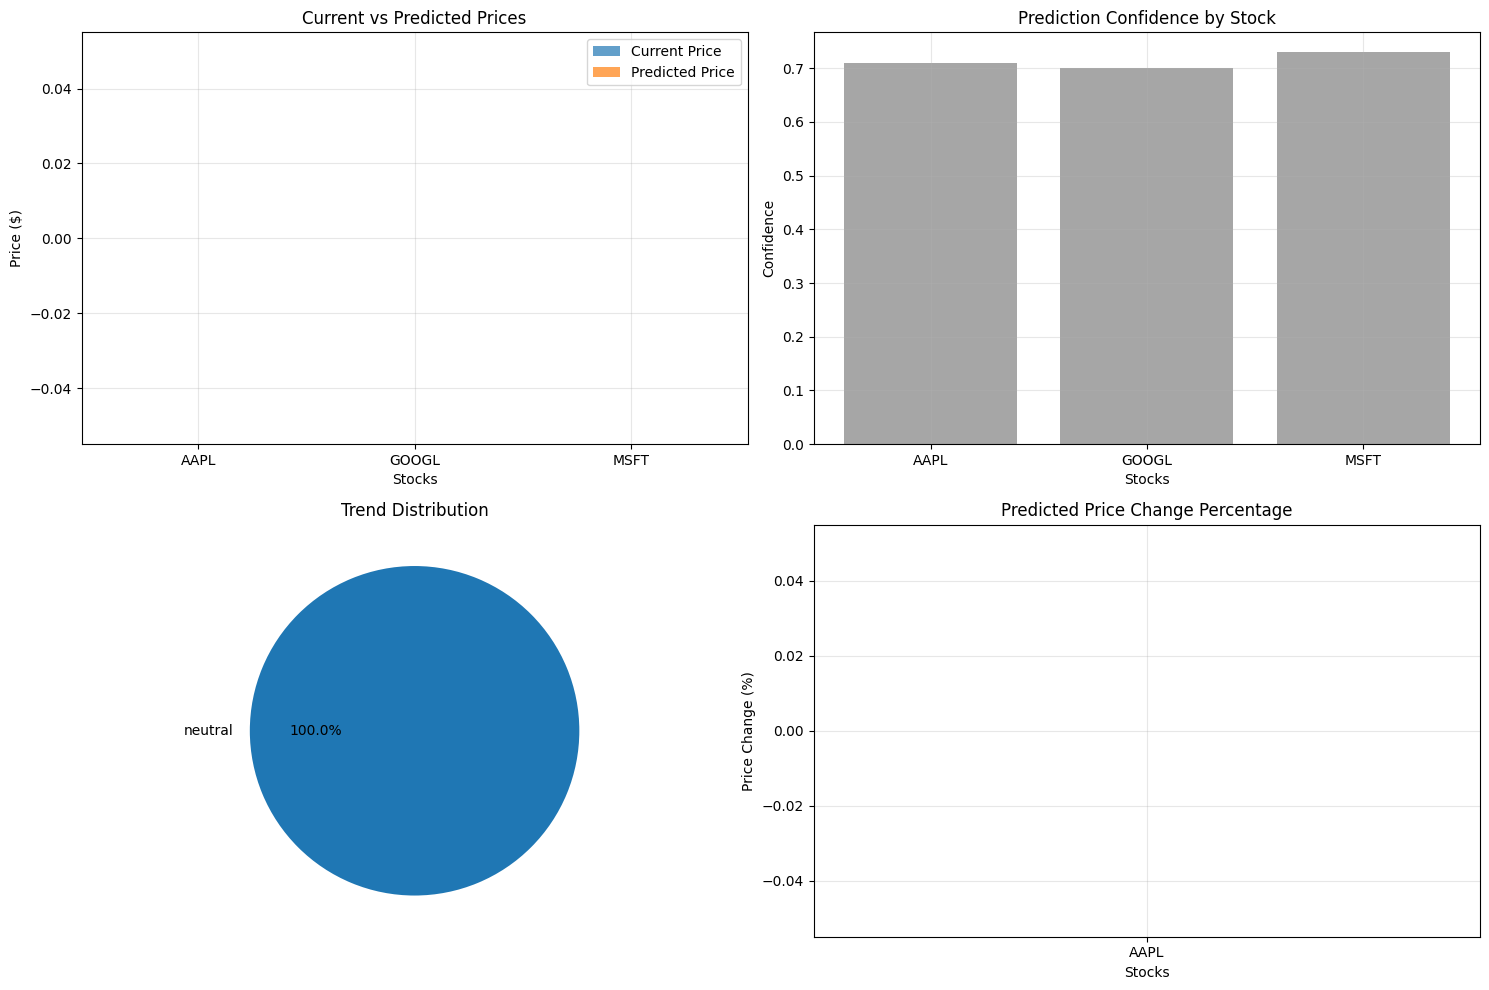


📋 Results Summary:
ticker  current_price  predicted_price   trend  confidence  price_change_%
  AAPL            0.0              0.0 neutral        0.71             NaN
 GOOGL            0.0              0.0 neutral        0.70             NaN
  MSFT            0.0              0.0 neutral        0.73             NaN


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_prediction_results(tickers: List[str]):
    """Visualize prediction results for multiple stocks"""
    results = []
    
    for ticker in tickers:
        try:
            result = predict_market_trend_standalone(ticker)
            results.append({
                'ticker': result['ticker'],
                'current_price': result['stock_info']['current_price'],
                'predicted_price': result['predicted_price'],
                'trend': result['trend'],
                'confidence': result['confidence']
            })
        except Exception as e:
            print(f"Error with {ticker}: {e}")
            continue
    
    if not results:
        print("No results to visualize")
        return
    
    df_results = pd.DataFrame(results)
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Price comparison
    x_pos = range(len(df_results))
    ax1.bar([x - 0.2 for x in x_pos], df_results['current_price'], width=0.4, label='Current Price', alpha=0.7)
    ax1.bar([x + 0.2 for x in x_pos], df_results['predicted_price'], width=0.4, label='Predicted Price', alpha=0.7)
    ax1.set_xlabel('Stocks')
    ax1.set_ylabel('Price ($)')
    ax1.set_title('Current vs Predicted Prices')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df_results['ticker'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Confidence levels
    colors = ['green' if trend == 'up' else 'red' if trend == 'down' else 'gray' for trend in df_results['trend']]
    ax2.bar(df_results['ticker'], df_results['confidence'], color=colors, alpha=0.7)
    ax2.set_xlabel('Stocks')
    ax2.set_ylabel('Confidence')
    ax2.set_title('Prediction Confidence by Stock')
    ax2.grid(True, alpha=0.3)
    
    # Trend distribution
    trend_counts = df_results['trend'].value_counts()
    ax3.pie(trend_counts.values, labels=trend_counts.index, autopct='%1.1f%%')
    ax3.set_title('Trend Distribution')
    
    # Price change percentage
    df_results['price_change_%'] = ((df_results['predicted_price'] - df_results['current_price']) / df_results['current_price']) * 100
    colors = ['green' if x > 0 else 'red' for x in df_results['price_change_%']]
    ax4.bar(df_results['ticker'], df_results['price_change_%'], color=colors, alpha=0.7)
    ax4.set_xlabel('Stocks')
    ax4.set_ylabel('Price Change (%)')
    ax4.set_title('Predicted Price Change Percentage')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df_results

# Example usage
test_tickers = ["AAPL", "GOOGL", "MSFT"]
print("📊 Creating visualization...")
viz_results = visualize_prediction_results(test_tickers)

if viz_results is not None:
    print("\n📋 Results Summary:")
    print(viz_results.to_string(index=False))